In [1]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import keras
from numpy import array
from numpy import hstack
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/Timeseries_test/big_alldata.csv"
df_use = pd.read_csv(data_path)

In [5]:
df_use.columns

Index(['0', 'PM_Routine', 'Routine_Routine', 'General_Routine',
       'OVERHAUL_Routine', 'PdM_Routine', 'CFT_Routine', 'CM_Non-Routine',
       'REC_Non-Routine', 'MoD_Non-Routine', 'PM_Routine_WORK_NOT_DONE',
       'Routine_Routine_WORK_NOT_DONE', 'General_Routine_WORK_NOT_DONE',
       'OVERHAUL_Routine_WORK_NOT_DONE', 'PdM_Routine_WORK_NOT_DONE',
       'CFT_Routine_WORK_NOT_DONE', 'CM_Non-Routine_WORK_NOT_DONE',
       'REC_Non-Routine_WORK_NOT_DONE', 'MoD_Non-Routine_WORK_NOT_DONE',
       'PM_Routine_WORK_DONE', 'Routine_Routine_WORK_DONE',
       'General_Routine_WORK_DONE', 'OVERHAUL_Routine_WORK_DONE',
       'PdM_Routine_WORK_DONE', 'CFT_Routine_WORK_DONE',
       'CM_Non-Routine_WORK_DONE', 'REC_Non-Routine_WORK_DONE',
       'MoD_Non-Routine_WORK_DONE', 'PM_Routine_DAY_NOT_DONE',
       'Routine_Routine_DAY_NOT_DONE', 'General_Routine_DAY_NOT_DONE',
       'OVERHAUL_Routine_DAY_NOT_DONE', 'PdM_Routine_DAY_NOT_DONE',
       'CFT_Routine_DAY_NOT_DONE', 'CM_Non-Routine_DAY_

In [6]:
def get_data(df_use):
  df_use = df_use.rename(columns = {'0':'Date'})
  col = ['Date','PM_Routine','General_Routine','CM_Non-Routine']
  extension = ['_WORK_NOT_DONE','_WORK_DONE','_DAY_NOT_DONE','_DAY_DONE']

  col_ex = []
  for e in extension:
      col_ex.append(col[3] + e)
  col += col_ex
  df = df_use[col]
  df['Date']= pd.to_datetime(df['Date'])
  df = df[(df['Date'] <= '2021-12-12') & (df['Date'] >= '2017-07-01')]
  df = df.reset_index(drop=True)
  time = df.iloc[:,0]
  df = df.iloc[:,1:]
  return time, df

In [7]:
time_df,df = get_data(df_use)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [10]:
df_CM_non_routine = df["CM_Non-Routine"].to_list()

In [12]:
df = df[:-30]

In [16]:
df["CM_NON-Routine"] = df_CM_non_routine[30:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
n = len(df)
x_train = df[0:int(n*0.7)]
x_valid = df[int(n*0.7):int(n*0.9)]
x_test = df[int(n*0.9):]
time_train = time_df[0:int(n*0.7)]
time_valid = time_df[int(n*0.7):int(n*0.9)]
time_predict = time_df[int(n*0.9):]

mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean)/std
x_valid = (x_valid - mean)/std
x_test = (x_test - mean)/std

In [28]:
print(n)

1596


In [19]:
x_train.columns

Index(['PM_Routine', 'General_Routine', 'CM_Non-Routine',
       'CM_Non-Routine_WORK_NOT_DONE', 'CM_Non-Routine_WORK_DONE',
       'CM_Non-Routine_DAY_NOT_DONE', 'CM_Non-Routine_DAY_DONE',
       'CM_NON-Routine'],
      dtype='object')

In [20]:
class WindowGenerator():
    def __init__(self, train_df, val_df, test_df,input_features, 
                 label_features, input_width, label_width, shift=0):
        # Store the raw data.
        # self.train_df = train_df
        # self.val_df = val_df
        # self.test_df = test_df
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        print(self.train_df.columns)

        self.input_features=input_features
        self.label_features=label_features

        self.indices_features = {name: i for i, name in
                            enumerate(self.train_df.columns)}
        # self.indices_features = input_features
        # Work out the label column indices.


        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift + label_width


        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        label_start = input_width + shift
        self.label_slice = slice(label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]

    def split_window(self, features):
        # print(features)
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        
        inputs = tf.stack(
            [labels[:, :, self.indices_features[name]] for name in self.input_features],
            axis=-1)
        labels = tf.stack(
            [labels[:, :, self.indices_features[name]] for name in self.label_features],
            axis=-1)
        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, dataset ,shuffle=True):
        ds_dataset = None
        # print(len(dataset))
        data = np.array(dataset, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32)

        ds = ds.map(self.split_window)
        if ds_dataset is None:
            ds_dataset = ds
        else:
            ds_dataset = ds_dataset.concatenate(ds)
    
        return ds_dataset

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df, shuffle=False)

    
        
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
        # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
        # And cache it for next time
            self._example = result
        return result
    # def __repr__(self):
    #     return '\n'.join([
    #         f'Total window size: {self.total_window_size}',
    #         f'Input indices: {self.input_indices}',
    #         f'Label indices: {self.label_indices}',
    #         f'Label column name(s): {self.label_columns}'])

In [21]:
input_features = x_train.columns.to_list()
output_features = [x_train.columns.to_list()[2]]

num_input_features = len(input_features)
num_output_features = len(output_features)

indices_features = {name: i for i,name in enumerate(input_features)}
indices_input_features = {name: i for i,name in enumerate(input_features)}
indices_output_features = {name: i for i,name in enumerate(output_features)}

IN_STEPS = 30
OUT_STEPS = 30

In [22]:
multi_window = WindowGenerator(x_train,x_valid,x_test,
                   input_features=input_features, label_features=output_features, 
                    input_width=IN_STEPS, label_width=OUT_STEPS,shift = 29)

Index(['PM_Routine', 'General_Routine', 'CM_Non-Routine',
       'CM_Non-Routine_WORK_NOT_DONE', 'CM_Non-Routine_WORK_DONE',
       'CM_Non-Routine_DAY_NOT_DONE', 'CM_Non-Routine_DAY_DONE',
       'CM_NON-Routine'],
      dtype='object')


In [23]:
checkpoint_path = "/content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/"

In [24]:
print(multi_window.train)

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


In [ ]:
print(multi_window.val)

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


In [ ]:
print(multi_window.test)

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


In [25]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, model_name, patience=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + model_name, monitor='val_loss', save_best_only=True, save_feq='epoch')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val, callbacks=[early_stopping,model_checkpoint])
    # history = model.fit(window.train, epochs=MAX_EPOCHS,callbacks=[early_stopping,model_checkpoint])
    return history

**LSTM**

In [26]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    LSTM(200, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    LSTM(200, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features].
    Dense(200),
    Dense(OUT_STEPS*num_output_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_output_features])
])

In [29]:
history = compile_and_fit(multi_lstm_model, multi_window, 'lstm_3to1_30shift=29')

Epoch 1/200
32/33 [============================>.] - ETA: 0s - loss: 0.5853 - mean_absolute_error: 0.4659

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 5s 96ms/step - loss: 0.5850 - mean_absolute_error: 0.4661 - val_loss: 0.2520 - val_mean_absolute_error: 0.2930
Epoch 2/200
30/33 [==========================>...] - ETA: 0s - loss: 0.5462 - mean_absolute_error: 0.4490

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 3s 86ms/step - loss: 0.5377 - mean_absolute_error: 0.4456 - val_loss: 0.2292 - val_mean_absolute_error: 0.2659
Epoch 3/200
31/33 [===========================>..] - ETA: 0s - loss: 0.5170 - mean_absolute_error: 0.4384

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 72ms/step - loss: 0.5130 - mean_absolute_error: 0.4374 - val_loss: 0.2252 - val_mean_absolute_error: 0.2575
Epoch 4/200
33/33 [==============================] - ETA: 0s - loss: 0.4846 - mean_absolute_error: 0.4246

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 72ms/step - loss: 0.4846 - mean_absolute_error: 0.4246 - val_loss: 0.1992 - val_mean_absolute_error: 0.2472
Epoch 5/200
29/33 [=========================>....] - ETA: 0s - loss: 0.4517 - mean_absolute_error: 0.4166

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 76ms/step - loss: 0.4493 - mean_absolute_error: 0.4143 - val_loss: 0.1939 - val_mean_absolute_error: 0.2447
Epoch 6/200
31/33 [===========================>..] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.4046

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 72ms/step - loss: 0.4278 - mean_absolute_error: 0.4047 - val_loss: 0.1846 - val_mean_absolute_error: 0.2288
Epoch 7/200
33/33 [==============================] - 1s 16ms/step - loss: 0.4088 - mean_absolute_error: 0.3956 - val_loss: 0.1897 - val_mean_absolute_error: 0.2280
Epoch 8/200
31/33 [===========================>..] - ETA: 0s - loss: 0.3905 - mean_absolute_error: 0.3883

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 3s 81ms/step - loss: 0.3942 - mean_absolute_error: 0.3892 - val_loss: 0.1760 - val_mean_absolute_error: 0.2147
Epoch 9/200
33/33 [==============================] - 1s 14ms/step - loss: 0.3786 - mean_absolute_error: 0.3819 - val_loss: 0.1888 - val_mean_absolute_error: 0.2245
Epoch 10/200
33/33 [==============================] - 1s 14ms/step - loss: 0.4099 - mean_absolute_error: 0.3969 - val_loss: 0.1785 - val_mean_absolute_error: 0.2404
Epoch 11/200
32/33 [============================>.] - ETA: 0s - loss: 0.3686 - mean_absolute_error: 0.3772

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 71ms/step - loss: 0.3685 - mean_absolute_error: 0.3773 - val_loss: 0.1669 - val_mean_absolute_error: 0.2246
Epoch 12/200
29/33 [=========================>....] - ETA: 0s - loss: 0.3619 - mean_absolute_error: 0.3740

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 73ms/step - loss: 0.3588 - mean_absolute_error: 0.3710 - val_loss: 0.1566 - val_mean_absolute_error: 0.2033
Epoch 13/200
28/33 [========================>.....] - ETA: 0s - loss: 0.3407 - mean_absolute_error: 0.3632

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 74ms/step - loss: 0.3410 - mean_absolute_error: 0.3628 - val_loss: 0.1530 - val_mean_absolute_error: 0.1995
Epoch 14/200
33/33 [==============================] - 1s 15ms/step - loss: 0.3315 - mean_absolute_error: 0.3581 - val_loss: 0.1687 - val_mean_absolute_error: 0.2152
Epoch 15/200
31/33 [===========================>..] - ETA: 0s - loss: 0.3308 - mean_absolute_error: 0.3587

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 73ms/step - loss: 0.3297 - mean_absolute_error: 0.3581 - val_loss: 0.1516 - val_mean_absolute_error: 0.2016
Epoch 16/200
28/33 [========================>.....] - ETA: 0s - loss: 0.3153 - mean_absolute_error: 0.3521

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 73ms/step - loss: 0.3208 - mean_absolute_error: 0.3541 - val_loss: 0.1420 - val_mean_absolute_error: 0.1990
Epoch 17/200
30/33 [==========================>...] - ETA: 0s - loss: 0.3129 - mean_absolute_error: 0.3510

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 75ms/step - loss: 0.3112 - mean_absolute_error: 0.3507 - val_loss: 0.1375 - val_mean_absolute_error: 0.1951
Epoch 18/200
33/33 [==============================] - ETA: 0s - loss: 0.3065 - mean_absolute_error: 0.3463

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 3s 83ms/step - loss: 0.3065 - mean_absolute_error: 0.3463 - val_loss: 0.1360 - val_mean_absolute_error: 0.1985
Epoch 19/200
28/33 [========================>.....] - ETA: 0s - loss: 0.3038 - mean_absolute_error: 0.3485

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 74ms/step - loss: 0.3026 - mean_absolute_error: 0.3479 - val_loss: 0.1315 - val_mean_absolute_error: 0.1889
Epoch 20/200
33/33 [==============================] - 1s 15ms/step - loss: 0.3101 - mean_absolute_error: 0.3481 - val_loss: 0.1413 - val_mean_absolute_error: 0.1903
Epoch 21/200
32/33 [============================>.] - ETA: 0s - loss: 0.2972 - mean_absolute_error: 0.3415

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 72ms/step - loss: 0.2963 - mean_absolute_error: 0.3409 - val_loss: 0.1291 - val_mean_absolute_error: 0.1895
Epoch 22/200
33/33 [==============================] - 1s 14ms/step - loss: 0.2907 - mean_absolute_error: 0.3385 - val_loss: 0.1379 - val_mean_absolute_error: 0.1971
Epoch 23/200
33/33 [==============================] - 1s 15ms/step - loss: 0.3148 - mean_absolute_error: 0.3482 - val_loss: 0.1339 - val_mean_absolute_error: 0.1975
Epoch 24/200
33/33 [==============================] - 1s 17ms/step - loss: 0.2998 - mean_absolute_error: 0.3431 - val_loss: 0.1497 - val_mean_absolute_error: 0.2001
Epoch 25/200
33/33 [==============================] - ETA: 0s - loss: 0.2886 - mean_absolute_error: 0.3371

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 73ms/step - loss: 0.2886 - mean_absolute_error: 0.3371 - val_loss: 0.1286 - val_mean_absolute_error: 0.1894
Epoch 26/200
30/33 [==========================>...] - ETA: 0s - loss: 0.2724 - mean_absolute_error: 0.3305

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 75ms/step - loss: 0.2743 - mean_absolute_error: 0.3311 - val_loss: 0.1282 - val_mean_absolute_error: 0.1841
Epoch 27/200
33/33 [==============================] - 1s 27ms/step - loss: 0.2753 - mean_absolute_error: 0.3323 - val_loss: 0.1294 - val_mean_absolute_error: 0.1901
Epoch 28/200
33/33 [==============================] - 1s 18ms/step - loss: 0.2654 - mean_absolute_error: 0.3270 - val_loss: 0.1287 - val_mean_absolute_error: 0.1843
Epoch 29/200
33/33 [==============================] - 1s 16ms/step - loss: 0.2639 - mean_absolute_error: 0.3271 - val_loss: 0.1295 - val_mean_absolute_error: 0.1940
Epoch 30/200
33/33 [==============================] - 1s 15ms/step - loss: 0.2642 - mean_absolute_error: 0.3244 - val_loss: 0.1377 - val_mean_absolute_error: 0.1886
Epoch 31/200
33/33 [==============================] - 0s 14ms/step - loss: 0.2726 - mean_absolute_error: 0.3280 - val_loss: 0.1317 - val_mean_absolute_error: 0.1914
Epoch 32/200
30/33 [===

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 72ms/step - loss: 0.2560 - mean_absolute_error: 0.3223 - val_loss: 0.1211 - val_mean_absolute_error: 0.1770
Epoch 33/200
33/33 [==============================] - 1s 15ms/step - loss: 0.2554 - mean_absolute_error: 0.3217 - val_loss: 0.1306 - val_mean_absolute_error: 0.1903
Epoch 34/200
33/33 [==============================] - 1s 15ms/step - loss: 0.2594 - mean_absolute_error: 0.3207 - val_loss: 0.1226 - val_mean_absolute_error: 0.1778
Epoch 35/200
33/33 [==============================] - 1s 15ms/step - loss: 0.2532 - mean_absolute_error: 0.3193 - val_loss: 0.1214 - val_mean_absolute_error: 0.1786
Epoch 36/200
33/33 [==============================] - 1s 18ms/step - loss: 0.2430 - mean_absolute_error: 0.3151 - val_loss: 0.1257 - val_mean_absolute_error: 0.1818
Epoch 37/200
33/33 [==============================] - 0s 14ms/step - loss: 0.2415 - mean_absolute_error: 0.3150 - val_loss: 0.1235 - val_mean_absolute_error: 0.1831
Epoch 38/200
33/33 [===

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 5s 138ms/step - loss: 0.2217 - mean_absolute_error: 0.3048 - val_loss: 0.1206 - val_mean_absolute_error: 0.1752
Epoch 49/200
33/33 [==============================] - 1s 16ms/step - loss: 0.2193 - mean_absolute_error: 0.3040 - val_loss: 0.1248 - val_mean_absolute_error: 0.1810
Epoch 50/200
33/33 [==============================] - 1s 17ms/step - loss: 0.2150 - mean_absolute_error: 0.3006 - val_loss: 0.1224 - val_mean_absolute_error: 0.1775
Epoch 51/200
33/33 [==============================] - 1s 15ms/step - loss: 0.2143 - mean_absolute_error: 0.3009 - val_loss: 0.1263 - val_mean_absolute_error: 0.1829
Epoch 52/200
33/33 [==============================] - 0s 14ms/step - loss: 0.2146 - mean_absolute_error: 0.3009 - val_loss: 0.1243 - val_mean_absolute_error: 0.1778
Epoch 53/200
33/33 [==============================] - 0s 14ms/step - loss: 0.2103 - mean_absolute_error: 0.2994 - val_loss: 0.1215 - val_mean_absolute_error: 0.1769
Epoch 54/200
33/33 [==

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 72ms/step - loss: 0.2081 - mean_absolute_error: 0.2967 - val_loss: 0.1182 - val_mean_absolute_error: 0.1758
Epoch 58/200
33/33 [==============================] - 1s 15ms/step - loss: 0.2055 - mean_absolute_error: 0.2961 - val_loss: 0.1236 - val_mean_absolute_error: 0.1792
Epoch 59/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1997 - mean_absolute_error: 0.2942 - val_loss: 0.1221 - val_mean_absolute_error: 0.1772
Epoch 60/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1970 - mean_absolute_error: 0.2914 - val_loss: 0.1214 - val_mean_absolute_error: 0.1739
Epoch 61/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1939 - mean_absolute_error: 0.2892 - val_loss: 0.1221 - val_mean_absolute_error: 0.1808
Epoch 62/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1955 - mean_absolute_error: 0.2918 - val_loss: 0.1219 - val_mean_absolute_error: 0.1760
Epoch 63/200
33/33 [===

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 75ms/step - loss: 0.1818 - mean_absolute_error: 0.2843 - val_loss: 0.1166 - val_mean_absolute_error: 0.1683
Epoch 70/200
33/33 [==============================] - 1s 16ms/step - loss: 0.1804 - mean_absolute_error: 0.2823 - val_loss: 0.1186 - val_mean_absolute_error: 0.1691
Epoch 71/200
33/33 [==============================] - 1s 19ms/step - loss: 0.1778 - mean_absolute_error: 0.2816 - val_loss: 0.1179 - val_mean_absolute_error: 0.1739
Epoch 72/200
33/33 [==============================] - 1s 16ms/step - loss: 0.1783 - mean_absolute_error: 0.2816 - val_loss: 0.1225 - val_mean_absolute_error: 0.1742
Epoch 73/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1775 - mean_absolute_error: 0.2812 - val_loss: 0.1180 - val_mean_absolute_error: 0.1717
Epoch 74/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1790 - mean_absolute_error: 0.2806 - val_loss: 0.1182 - val_mean_absolute_error: 0.1718
Epoch 75/200
33/33 [===

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 3s 90ms/step - loss: 0.1705 - mean_absolute_error: 0.2779 - val_loss: 0.1108 - val_mean_absolute_error: 0.1627
Epoch 78/200
33/33 [==============================] - 1s 16ms/step - loss: 0.1661 - mean_absolute_error: 0.2741 - val_loss: 0.1156 - val_mean_absolute_error: 0.1716
Epoch 79/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1703 - mean_absolute_error: 0.2768 - val_loss: 0.1150 - val_mean_absolute_error: 0.1695
Epoch 80/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1646 - mean_absolute_error: 0.2735 - val_loss: 0.1169 - val_mean_absolute_error: 0.1701
Epoch 81/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1632 - mean_absolute_error: 0.2717 - val_loss: 0.1111 - val_mean_absolute_error: 0.1644
Epoch 82/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1615 - mean_absolute_error: 0.2715 - val_loss: 0.1141 - val_mean_absolute_error: 0.1654
Epoch 83/200
33/33 [===

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 72ms/step - loss: 0.1456 - mean_absolute_error: 0.2607 - val_loss: 0.1085 - val_mean_absolute_error: 0.1629
Epoch 93/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1446 - mean_absolute_error: 0.2602 - val_loss: 0.1131 - val_mean_absolute_error: 0.1673
Epoch 94/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1457 - mean_absolute_error: 0.2603 - val_loss: 0.1191 - val_mean_absolute_error: 0.1729
Epoch 95/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1491 - mean_absolute_error: 0.2666 - val_loss: 0.1115 - val_mean_absolute_error: 0.1657
Epoch 96/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1444 - mean_absolute_error: 0.2625 - val_loss: 0.1131 - val_mean_absolute_error: 0.1673
Epoch 97/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1419 - mean_absolute_error: 0.2588 - val_loss: 0.1114 - val_mean_absolute_error: 0.1724
Epoch 98/200
33/33 [===

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 72ms/step - loss: 0.1307 - mean_absolute_error: 0.2510 - val_loss: 0.1080 - val_mean_absolute_error: 0.1606
Epoch 105/200
31/33 [===========================>..] - ETA: 0s - loss: 0.1327 - mean_absolute_error: 0.2532

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 3s 78ms/step - loss: 0.1320 - mean_absolute_error: 0.2524 - val_loss: 0.1060 - val_mean_absolute_error: 0.1625
Epoch 106/200
33/33 [==============================] - 1s 18ms/step - loss: 0.1288 - mean_absolute_error: 0.2494 - val_loss: 0.1091 - val_mean_absolute_error: 0.1698
Epoch 107/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1277 - mean_absolute_error: 0.2482 - val_loss: 0.1115 - val_mean_absolute_error: 0.1691
Epoch 108/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1276 - mean_absolute_error: 0.2475 - val_loss: 0.1086 - val_mean_absolute_error: 0.1672
Epoch 109/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1262 - mean_absolute_error: 0.2468 - val_loss: 0.1086 - val_mean_absolute_error: 0.1650
Epoch 110/200
32/33 [============================>.] - ETA: 0s - loss: 0.1265 - mean_absolute_error: 0.2471

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 73ms/step - loss: 0.1264 - mean_absolute_error: 0.2470 - val_loss: 0.1060 - val_mean_absolute_error: 0.1666
Epoch 111/200
29/33 [=========================>....] - ETA: 0s - loss: 0.1250 - mean_absolute_error: 0.2456

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 73ms/step - loss: 0.1241 - mean_absolute_error: 0.2452 - val_loss: 0.1033 - val_mean_absolute_error: 0.1597
Epoch 112/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1238 - mean_absolute_error: 0.2449 - val_loss: 0.1073 - val_mean_absolute_error: 0.1635
Epoch 113/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1230 - mean_absolute_error: 0.2451 - val_loss: 0.1055 - val_mean_absolute_error: 0.1596
Epoch 114/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1224 - mean_absolute_error: 0.2438 - val_loss: 0.1093 - val_mean_absolute_error: 0.1692
Epoch 115/200
33/33 [==============================] - 0s 13ms/step - loss: 0.1222 - mean_absolute_error: 0.2448 - val_loss: 0.1061 - val_mean_absolute_error: 0.1645
Epoch 116/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1218 - mean_absolute_error: 0.2446 - val_loss: 0.1060 - val_mean_absolute_error: 0.1625
Epoch 117/200
33/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 75ms/step - loss: 0.1179 - mean_absolute_error: 0.2397 - val_loss: 0.1032 - val_mean_absolute_error: 0.1591
Epoch 119/200
33/33 [==============================] - 1s 16ms/step - loss: 0.1217 - mean_absolute_error: 0.2450 - val_loss: 0.1097 - val_mean_absolute_error: 0.1664
Epoch 120/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1179 - mean_absolute_error: 0.2407 - val_loss: 0.1076 - val_mean_absolute_error: 0.1622
Epoch 121/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1141 - mean_absolute_error: 0.2369 - val_loss: 0.1039 - val_mean_absolute_error: 0.1616
Epoch 122/200
33/33 [==============================] - 1s 14ms/step - loss: 0.1178 - mean_absolute_error: 0.2411 - val_loss: 0.1070 - val_mean_absolute_error: 0.1657
Epoch 123/200
33/33 [==============================] - 0s 14ms/step - loss: 0.1172 - mean_absolute_error: 0.2407 - val_loss: 0.1079 - val_mean_absolute_error: 0.1656
Epoch 124/200
33/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 76ms/step - loss: 0.1074 - mean_absolute_error: 0.2316 - val_loss: 0.1031 - val_mean_absolute_error: 0.1631
Epoch 132/200
31/33 [===========================>..] - ETA: 0s - loss: 0.1069 - mean_absolute_error: 0.2309

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 76ms/step - loss: 0.1070 - mean_absolute_error: 0.2309 - val_loss: 0.1025 - val_mean_absolute_error: 0.1593
Epoch 133/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1085 - mean_absolute_error: 0.2318 - val_loss: 0.1039 - val_mean_absolute_error: 0.1635
Epoch 134/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1067 - mean_absolute_error: 0.2307 - val_loss: 0.1059 - val_mean_absolute_error: 0.1643
Epoch 135/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1031 - mean_absolute_error: 0.2274 - val_loss: 0.1044 - val_mean_absolute_error: 0.1610
Epoch 136/200
29/33 [=========================>....] - ETA: 0s - loss: 0.1015 - mean_absolute_error: 0.2265

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 3s 93ms/step - loss: 0.1009 - mean_absolute_error: 0.2257 - val_loss: 0.1009 - val_mean_absolute_error: 0.1592
Epoch 137/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1007 - mean_absolute_error: 0.2255 - val_loss: 0.1055 - val_mean_absolute_error: 0.1607
Epoch 138/200
33/33 [==============================] - 1s 24ms/step - loss: 0.1004 - mean_absolute_error: 0.2248 - val_loss: 0.1047 - val_mean_absolute_error: 0.1620
Epoch 139/200
33/33 [==============================] - 1s 18ms/step - loss: 0.1033 - mean_absolute_error: 0.2265 - val_loss: 0.1055 - val_mean_absolute_error: 0.1583
Epoch 140/200
33/33 [==============================] - ETA: 0s - loss: 0.1012 - mean_absolute_error: 0.2247

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 75ms/step - loss: 0.1012 - mean_absolute_error: 0.2247 - val_loss: 0.0990 - val_mean_absolute_error: 0.1601
Epoch 141/200
33/33 [==============================] - 1s 16ms/step - loss: 0.1053 - mean_absolute_error: 0.2298 - val_loss: 0.1061 - val_mean_absolute_error: 0.1610
Epoch 142/200
33/33 [==============================] - 1s 15ms/step - loss: 0.1035 - mean_absolute_error: 0.2280 - val_loss: 0.1036 - val_mean_absolute_error: 0.1582
Epoch 143/200
33/33 [==============================] - 1s 19ms/step - loss: 0.0979 - mean_absolute_error: 0.2226 - val_loss: 0.1057 - val_mean_absolute_error: 0.1633
Epoch 144/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0969 - mean_absolute_error: 0.2215 - val_loss: 0.1032 - val_mean_absolute_error: 0.1623
Epoch 145/200
33/33 [==============================] - 1s 14ms/step - loss: 0.0964 - mean_absolute_error: 0.2207 - val_loss: 0.1031 - val_mean_absolute_error: 0.1586
Epoch 146/200
33/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 75ms/step - loss: 0.0918 - mean_absolute_error: 0.2158 - val_loss: 0.0974 - val_mean_absolute_error: 0.1585
Epoch 151/200
33/33 [==============================] - 1s 16ms/step - loss: 0.0912 - mean_absolute_error: 0.2161 - val_loss: 0.1006 - val_mean_absolute_error: 0.1559
Epoch 152/200
33/33 [==============================] - 1s 15ms/step - loss: 0.0894 - mean_absolute_error: 0.2144 - val_loss: 0.0990 - val_mean_absolute_error: 0.1548
Epoch 153/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0899 - mean_absolute_error: 0.2142 - val_loss: 0.1033 - val_mean_absolute_error: 0.1664
Epoch 154/200
33/33 [==============================] - 1s 14ms/step - loss: 0.0900 - mean_absolute_error: 0.2140 - val_loss: 0.1011 - val_mean_absolute_error: 0.1600
Epoch 155/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0911 - mean_absolute_error: 0.2153 - val_loss: 0.0975 - val_mean_absolute_error: 0.1552
Epoch 156/200
33/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 3s 81ms/step - loss: 0.0871 - mean_absolute_error: 0.2110 - val_loss: 0.0952 - val_mean_absolute_error: 0.1541
Epoch 162/200
33/33 [==============================] - 1s 15ms/step - loss: 0.0853 - mean_absolute_error: 0.2098 - val_loss: 0.1011 - val_mean_absolute_error: 0.1566
Epoch 163/200
33/33 [==============================] - 1s 16ms/step - loss: 0.0836 - mean_absolute_error: 0.2071 - val_loss: 0.0959 - val_mean_absolute_error: 0.1515
Epoch 164/200
33/33 [==============================] - 1s 14ms/step - loss: 0.0841 - mean_absolute_error: 0.2068 - val_loss: 0.1007 - val_mean_absolute_error: 0.1562
Epoch 165/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0797 - mean_absolute_error: 0.2031 - val_loss: 0.0985 - val_mean_absolute_error: 0.1543
Epoch 166/200
33/33 [==============================] - 1s 14ms/step - loss: 0.0814 - mean_absolute_error: 0.2050 - val_loss: 0.0990 - val_mean_absolute_error: 0.1566
Epoch 167/200
33/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 3s 77ms/step - loss: 0.0831 - mean_absolute_error: 0.2059 - val_loss: 0.0926 - val_mean_absolute_error: 0.1520
Epoch 173/200
33/33 [==============================] - 1s 15ms/step - loss: 0.0792 - mean_absolute_error: 0.2025 - val_loss: 0.0975 - val_mean_absolute_error: 0.1525
Epoch 174/200
33/33 [==============================] - 1s 15ms/step - loss: 0.0747 - mean_absolute_error: 0.1982 - val_loss: 0.0989 - val_mean_absolute_error: 0.1613
Epoch 175/200
33/33 [==============================] - 1s 14ms/step - loss: 0.0763 - mean_absolute_error: 0.1992 - val_loss: 0.0973 - val_mean_absolute_error: 0.1566
Epoch 176/200
33/33 [==============================] - 1s 14ms/step - loss: 0.0755 - mean_absolute_error: 0.1975 - val_loss: 0.0958 - val_mean_absolute_error: 0.1537
Epoch 177/200
33/33 [==============================] - 0s 14ms/step - loss: 0.0734 - mean_absolute_error: 0.1956 - val_loss: 0.0963 - val_mean_absolute_error: 0.1521
Epoch 178/200
33/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 74ms/step - loss: 0.0642 - mean_absolute_error: 0.1839 - val_loss: 0.0922 - val_mean_absolute_error: 0.1444
Epoch 197/200
33/33 [==============================] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1806

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 2s 76ms/step - loss: 0.0625 - mean_absolute_error: 0.1806 - val_loss: 0.0916 - val_mean_absolute_error: 0.1471
Epoch 198/200
31/33 [===========================>..] - ETA: 0s - loss: 0.0646 - mean_absolute_error: 0.1828

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/WEIGHT_30to30_7features_v1/lstm_3to1_30shift=29/assets


33/33 [==============================] - 3s 78ms/step - loss: 0.0644 - mean_absolute_error: 0.1828 - val_loss: 0.0913 - val_mean_absolute_error: 0.1417
Epoch 199/200
33/33 [==============================] - 1s 16ms/step - loss: 0.0655 - mean_absolute_error: 0.1837 - val_loss: 0.0943 - val_mean_absolute_error: 0.1489
Epoch 200/200
33/33 [==============================] - 1s 15ms/step - loss: 0.0647 - mean_absolute_error: 0.1836 - val_loss: 0.1010 - val_mean_absolute_error: 0.1554


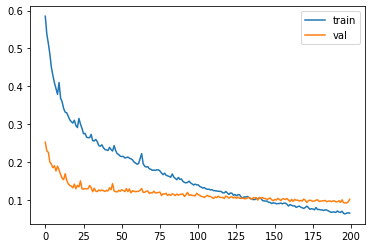

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

**CUSTOM ACCURACY**

In [31]:
test = multi_window.test
y_predict = multi_lstm_model.predict(test)
multi_lstm_model.evaluate(test)

3/3 [==============================] - 0s 8ms/step - loss: 0.0524 - mean_absolute_error: 0.1666


[0.052393339574337006, 0.16661952435970306]

In [ ]:
y_predict

In [33]:
y_test = []
data = x_test[output_features]
data = np.array(data, dtype=np.float32)
# data = data[7:,:]
data = data[30:,:]
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=30,
                sequence_stride=1,
                shuffle=False,
                batch_size=len(data))
for i in ds:
    y_test.append(np.array(i))
y_test = np.concatenate(y_test)

In [ ]:
y_test

In [36]:
std = np.array(std)[2]
mean = np.array(mean)[2]

In [37]:
print(len(y_test))
len(y_predict)

101


72

In [38]:
# y_true and y_predict has been inverted

def custome_accuracy(y_true, y_predict, feature ,bias=0.1,shift =29):
    index_col = indices_output_features[feature]
    y_true = y_true[:,shift,index_col]
    y_predict = y_predict[:,shift,index_col]
    # print(len(y_true))
    return np.mean(np.abs((y_true-y_predict)/y_true)<=bias)

In [39]:
print("{} : {}".format(output_features[0],custome_accuracy(y_test[29:] * std + mean,y_predict * std + mean,output_features[0])))

CM_Non-Routine : 0.3333333333333333


In [40]:
print(len(y_test))
print(len(y_predict))

101
72


In [41]:
def create_y_test(y_test):
    construct_y_test = []
    for i in range(len(y_test)):
        construct_y_test.append(y_test[i][0])
    for i in y_test[-1][1:]:
        construct_y_test.append(i)
    return construct_y_test

In [42]:
y_test_ = create_y_test(y_test)
y_predict_ = create_y_test(y_predict)

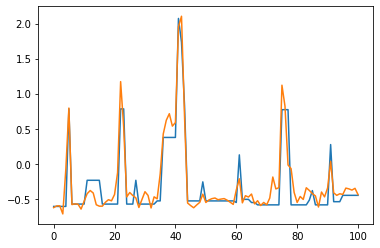

In [43]:
plt.plot(y_test_[29:])
plt.plot(y_predict_)

In [50]:
def custom_accuracy_0(y_true, y_predict ,bias=0.15,shift = 29):
    res = []
    for i in range(len(y_predict)):
      res.append(np.abs((y_true[i + shift]-y_predict[i])/y_true[i + shift]) <= bias)  
    return np.mean(res)

In [51]:
custom_accuracy_0(y_test_,y_predict_)

0.4752475247524752